<a href="https://colab.research.google.com/github/apoorvkh/notebooks/blob/main/Person%20Detection%20%2B%20Pose%20Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
%%bash
pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
pip install mmcv-full==latest+torch1.7.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html

In [ ]:
%%bash
git clone https://github.com/open-mmlab/mmdetection.git
cd mmdetection
pip install -r requirements/build.txt
pip install -v -e .
mkdir checkpoints
curl -o checkpoints/cascade_rcnn_r50_sac_1x_coco-24bfda62.pth http://download.openmmlab.com/mmdetection/v2.0/detectors/cascade_rcnn_r50_sac_1x_coco/cascade_rcnn_r50_sac_1x_coco-24bfda62.pth

In [ ]:
%%bash
git clone https://github.com/open-mmlab/mmpose.git
cd mmpose
pip install -r requirements.txt
python setup.py develop
mkdir checkpoints
curl -o checkpoints/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth

In [13]:
import sys
sys.path.append('mmdetection')
sys.path.append('mmpose')

# Loading Model

In [7]:
import mmcv

def load_image(image_path):
    image = mmcv.imread(image_path)
    w = image.shape[1]
    if w > 640:
        image = mmcv.imrescale(image, 640 / w)
        h, w = image.shape[:2]
    return image

In [24]:
from mmdet.apis import init_detector, inference_detector

det_config_file = 'mmdetection/configs/detectors/cascade_rcnn_r50_sac_1x_coco.py'
det_checkpoint_file = 'mmdetection/checkpoints/cascade_rcnn_r50_sac_1x_coco-24bfda62.pth'
det_thr = 0.8

det_model = init_detector(det_config_file, det_checkpoint_file, device='cuda:0')

def detect_boxes(image):
    boxes = inference_detector(det_model, image)[0]
    boxes = [{'bbox' : bb} for bb in boxes]
    return boxes

In [31]:
from mmpose.apis import init_pose_model, inference_top_down_pose_model

pose_config_file = 'mmpose/configs/top_down/darkpose/coco-wholebody/hrnet_w48_coco_wholebody_384x288_dark_plus.py'
pose_checkpoint_file = 'mmpose/checkpoints/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth'

pose_model = init_pose_model(pose_config_file, pose_checkpoint_file, device='cuda:0')

def estimate_poses(image, person_bboxes, thr):
    pose_result = inference_top_down_pose_model(pose_model, image, person_bboxes,
                                                bbox_thr=thr, format='xyxy',
                                                dataset='TopDownCocoWholeBodyDataset')[0]
    return pose_result

def process_result(pose_result, h, w):
    for i in range(len(pose_result)):
        pose_result[i]['bbox'] = pose_result[i]['bbox'][0] / [w, h, w, h, 1.0]
        pose_result[i]['keypoints'] = pose_result[i]['keypoints'] / [[w, h, 1.0]]
    return pose_result

# Inference

In [41]:
from mmpose.apis import vis_pose_result
from google.colab.patches import cv2_imshow

# Sample from MS COCO
!curl -o demo.jpg https://farm6.staticflickr.com/5183/5619918180_0b11e6a97d_z.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  112k    0  112k    0     0  2391k      0 --:--:-- --:--:-- --:--:-- 2391k


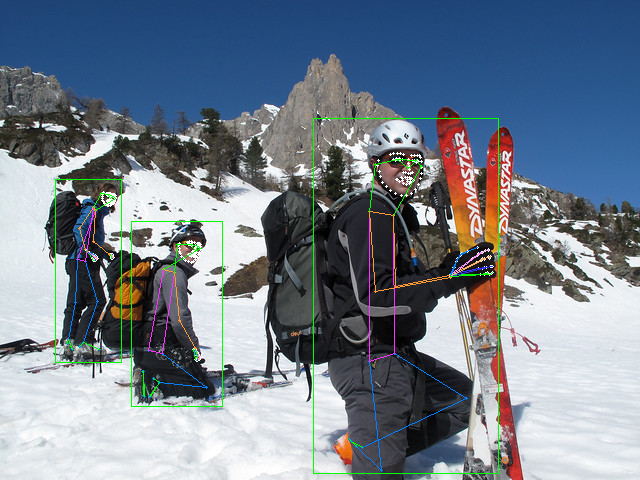

In [42]:
image = load_image('demo.jpg')
h, w = image.shape[:2]
boxes = detect_boxes(image)
pose_result = estimate_poses(image, boxes, det_thr)

vis = vis_pose_result(pose_model, image, pose_result, dataset='TopDownCocoWholeBodyDataset')
cv2_imshow(vis)